# Cheatsheet - Machine Learning

1. [Evaluation metrics](#evaluation-metrics)
2. [Scikit-learn](#scikit-learn)
3. [Feature selection](#feature-selection)
4. [Feature engineering](#feature-engineering)
5. [Clustering techniques](#clustering)
6. [K-means clustering](#k-means)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier

<a id='evaluation-metrics'></a>

## Evaluation metrics

### Classification
```
precision = TP / (TP + FP)
```
```
recall = TP / (TP + FN)
```
```
F1 = 2 * (precision * recall) / (precision + recall)
```
```
Area Under the ROC curve (AUC-ROC) (sensitivity and (1- specificity))
```

### Regression
```
Root Mean Squared Error (RMSE)
```
```
R^2 = MSE(model) / MSE(baseline)
```
```
Adjusted R-Squared penalizes for high number of features.
```

<a id='scikit-learn'></a>

## Scikit-learn

With scikit-learn you can:
- split a dataset with `train_test_split` into a train and test set
- create and __train a model__
- use the trained model to __make predictions__
- use the tools from `sklearn.metrics` to __evaluate the model__
- use __preprocessing__ techniques like scaling and encoding your categorical variables
    - [What algorithms need feature scaling, beside from SVM?](https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm)
- use of __pipelines__ to benefit from efficient code and reduce risks of data leakage

#### Example without pipeline

Model accuracy: 0.92
              precision    recall  f1-score   support

      Adelie       1.00      0.84      0.91        43
   Chinstrap       0.77      1.00      0.87        24
      Gentoo       0.97      0.97      0.97        33

    accuracy                           0.92       100
   macro avg       0.91      0.94      0.92       100
weighted avg       0.94      0.92      0.92       100



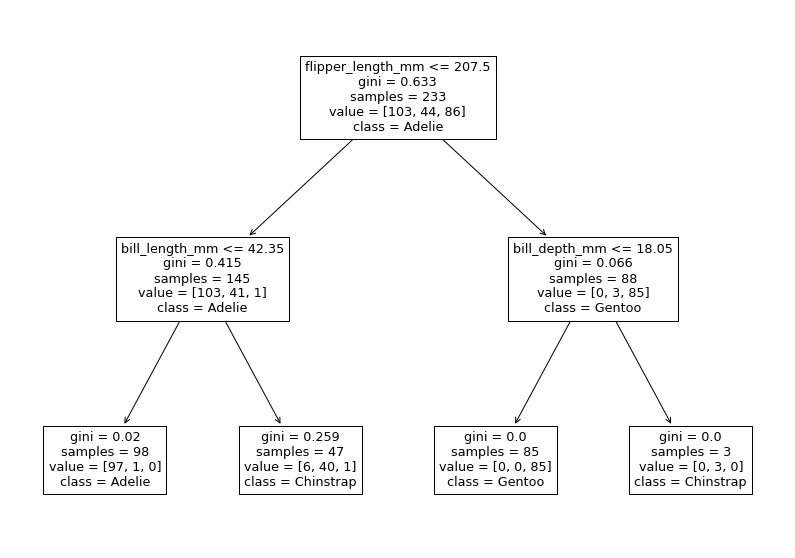

In [3]:
penguins = (
    pd.read_csv("data/penguins_dataset.csv")
    .dropna()
)
feature_columns = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

X = penguins[feature_columns]
y = penguins["species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

model = DecisionTreeClassifier(max_depth=2, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
print(f"Model accuracy: {model.score(X_test, y_test)}")
print(report)

fig, ax = plt.subplots(figsize=(14,10))

plot_tree(model, 
          ax=ax, 
          feature_names = feature_columns, 
          class_names = y.unique());

#### Example with pipeline

In [4]:
# Load and preprocess data
cars = (
    pd.read_csv("data/cars_dataset.csv")
    .rename(str.lower, axis="columns")
    .loc[lambda df: df["cylinders"] > 3]
    .dropna()
    .assign(year=lambda df: df["year"].str.slice(0,4).astype('int'))
)

# Prep train and test set
feature_columns = ["miles_per_gallon", "cylinders", "displacement", "horsepower", "acceleration", "year", "origin"]

X = cars[feature_columns]
y = cars["weight_in_lbs"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

# Initiate model
categorical_columns = ["origin"]

ct = ColumnTransformer(
    [
    ("onehot", OneHotEncoder(drop="first", handle_unknown="error"), categorical_columns)
    ], remainder="passthrough") 

model = Pipeline(steps=[
      ("encoding", ct),
      ("scaler", StandardScaler()),
      ("estimator", GradientBoostingRegressor())
])

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred  = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred).round(3)
mae = mean_absolute_error(y_test, y_pred).round(3)

print(f"R2: {r2}")
print(f"MAE: {mae}")

R2: 0.935
MAE: 142.638


<a id='feature-selection'></a>

## Feature selection

Exclude features if:

- Too many **missing values**  
- Too little value **variance** (see [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold))
- **High correlation** with the target or other features

Automatic feature selection methods:

- **Statistical testing** where little contributing features are removed (see [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)). 
- **Model-based selection** where a(n often penalized) model is used to the determine and eliminate the least contributing features (see [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)).

In practice, `SelectFromModel` is most often used in combination a _penalized_ model. By adding a special term to our regular cost function, the model is discouraged from unnecessary model complexity. 

The two most popular selection models used with `SelectFromModel` are  `Lasso` for regression problems and for classification `LinearSVC(penalty="l1")` - linear support vector machine classifier with an additional Lasso-like penalty term.

`Lasso` regression would punish a linear model for having too many large coefficients for variables that barely contribute for predictions. It will naturally push those coefficients towards zero, and therefore we can use it more easily as a feature selection technique:

$$ J_{L1}(\mathbf{w})= \frac{1}{n}\sum_{i=1}^n\left(y_i-y( \mathbf{w},\mathbf{x}^i) \right)^2 + \lambda \sum_{j=1}^m \left|w_j\right| $$


<a id='feature-engineering'></a>

## Feature engineering

* **Date and time features** Creating features from the dates available, e.g. is a holidays or day of the week. 
* **Group values** Grouping various numeric elements to a categorical variable, e.g. the months December (12), January (1) and February (2) to the season Winter. 
* **Grouping sparse classes** If you have a feature with an individual low sample count, you might group various values together under some other category. For example: if we had a column `bike_type` it would make sense to have stand-alone values such as `race`, `road` or `grandma`, whereas you might want to group values lik `penny farthing`, `unicycle` and `tricycle` together under a single `other` category since they are rarely rented.
* **Group from threshold** A new grouped variable for other variables, e.g. `warm` and `cold` based on the temperature.
* **Indicator from threshold** An indicator variable (0 or 1) based on a threshold on a column, e.g. eligible to vote/work based on age. 
* **Interaction of variables** The sum, difference, product or quotient of two features. E.g. `profit` as result of the difference between income and expenses. 


In [5]:
def get_date_values(df):
    """ Preprocessing function
    Creates year, month, day, hour columns.
    """
    df = df.assign(**{'year': df.index.year,
                      'month': df.index.month,
                      'day': df.index.day,
                      'hour': df.index.hour})
    
    return df

def is_holiday(df):
    """Return a new column is_holiday
    Input: dataframe (df) with date column (default datetime)
    True when the date is a holiday 
    False when the date is not a holiday"""
    
    return df.assign(is_holiday = pd.to_datetime(df.index.date).isin(HOLIDAYS))

def get_weekday(df):
    """Get the day of the week"""
    
    return df.assign(**{'weekday': df.index.day_name()})


def get_season(df):
    """Return the season based off:
    Dec, Jan, Feb = winter
    Mar, Apr, May = spring
    Jun, Jul, Aug = summer
    Sep, Oct, Nov = autumn"""
    
    season_mapping = {4: 'winter',
                      1: 'spring',
                      2: 'summer',
                      3: 'autumn'}
    
    # map the dates quarter to what season it is
    offset_months = df.index - pd.DateOffset(months=1)
    seasons = offset_months.quarter.map(season_mapping)
    
    return df.assign(season = seasons)

HOLIDAYS = ["2021-12-25", "2021-12-26"]

bikes = (
    pd.read_csv('data/bike_rental_dataset.csv', parse_dates = ['datetime'], index_col='datetime')
    .pipe(get_date_values)
    .pipe(is_holiday)
    .pipe(get_weekday)
    .pipe(get_season)
)

bikes.head()

weathersit  temp   atemp   hum  windspeed  cnt  year  \
datetime                                                                    
2011-01-01 00:00:00           1  0.24  0.2879  0.81        0.0   16  2011   
2011-01-01 01:00:00           1  0.22  0.2727  0.80        0.0   40  2011   
2011-01-01 02:00:00           1  0.22  0.2727  0.80        0.0   32  2011   
2011-01-01 03:00:00           1  0.24  0.2879  0.75        0.0   13  2011   
2011-01-01 04:00:00           1  0.24  0.2879  0.75        0.0    1  2011   

                     month  day  hour  is_holiday   weekday  season  
datetime                                                             
2011-01-01 00:00:00      1    1     0       False  Saturday  winter  
2011-01-01 01:00:00      1    1     1       False  Saturday  winter  
2011-01-01 02:00:00      1    1     2       False  Saturday  winter  
2011-01-01 03:00:00      1    1     3       False  Saturday  winter  
2011-01-01 04:00:00      1    1     4       False  Saturday  winter

<a id='clustering'></a>

## Clustering techniques

The three families of clustering algorithms are: 
1. __Partional__: k-means and Gaussian Mixture Models (GMM), where k-means is hard assigned version of GMMs and GMMs are able to provide probabilities
2. __Density-based__: DBSCAN and HDBSCAN.
3. __Hierarchical__: either agglomerative or divisive. These may correspond to meaningful taxonomies and a dendrogram can help find the most meaningful number of clusters.

### K-means

1. A number (_k_) of _centroids_ are initialised (centers of clusters). 
2. Each data point gets assigned to one out of _k_ clusters based on the minimal Euclidean distance between the data point and each centroid. 
3. The centroid of each cluster is recalculated to the average of the points in that cluster. 
4. Steps 2-3 are repeated until points no longer get reassigned.

#### Hopkins statistic
Determine _clusterability_ using the [_Hopkins statistic_](https://en.wikipedia.org/wiki/Hopkins_statistic). Essentially, the Hopkins statistic is calculated by sampling data points from the data set in question and for each sampled point finding its nearest neighbor. The mean distances (between the sampled points and their nearest neighbors) is compared to the mean distances between nearest neighbors in a simulated dataset from a random uniform distribution. 

A value of about 0.5 means the mean distances of the original dataset and the simulated dataset are close to each other, and thus the data is uniformly distributed. It does not have a tendency to cluster. If the value of Hopkins statistic is close to zero, the dataset is clusterable.  

#### Determine optimal number of clusters

- __Elbow method__: determine the elbow point of the graph, in the example it's clearly k=4. Unfortunately, the elbow is not always as sharp, i.e. the data is not as clearly clustered. 
- __Silhouette method__: in more ambiguous cases, this metric measures how similar a point is to its own cluster compared to other clusters. The range of the Silhouette value is between -1 and +1 and the higher it is, the better. 

![Elbow method](images/elbow-method.png)
![Silhouette method](images/silhouette-method.png)

The downside of k-means is that 
- it requires the number of clusters to be predefined.
- clusters must be circular shaped, k-means has no way of accounting for differently shaped clusters, such as oblong or elliptical. 

![Example of K-means](images/kmeans.gif)

### Gaussian Mixture Models (GMM)

Instead of a distanced-based model (k-means), GMM uses a distribution-based model. Gaussian Mixture Models are probabilistic models and use a soft clustering approach for distributing the points in different clusters. 

K-means can be seen as a version of Gaussian Mixture Models that hard assigns the clusters. However, GMMs are - as they are distribution based - more applicable to non-circular data shapes. 

The algorithm for Gaussian Mixture Models is as follows: 
1. A number (k) of centrois are initialised.
2. For each point in the dataset, find the probability of membership in each cluster. 
3. For each cluster, update its location, normalisation, and shape based on all the data points weighted by their probability of membership to the cluster. 
4. Steps 3-4 are repeated until points no longer get reassigned. 

![Example of GMM](images/gmm.gif)

### DBSCAN

DBSCAN stands for *Density-Based Spatial Clustering of Applications with Noise*. Essentially, DBSCAN looks for areas of high density and assigns clusters to them, whereas points in less dense regions are not even included in the clusters and labeled as anomalies. It has two key settings:

- *eps*: maximum distance between two points to consider them as neighbors. If this distance is too large we might end up with all the points in one huge cluster, however, if it is too small we might not even form a single cluster.
- *min_points*: minimum number of points to form a cluster. If we set a low value for this parameters we might end up with a lot of really small clusters, however, a large value can stop the algorithm from creating any clusters at all.

![Example of DBSCAN](images/DBSCAN_search.gif)

DBSCAN looks at how many neighbors (closer than *eps*) each point has, considering neighbors all the points closer than a certain distance (eps). If more than *min_points* are neighbors, then a cluster is created, and this cluster is expanded with all the neighbors of the neighbors. Intuitively, it is important to have the input data scaled.

### Hierarchical Clustering

HDBSCAN, the abbreviation for *Hierarchical Density-Based Spatial Clustering of Applications with Noise*, is an extension of DBSCAN and and appropriate choice for more randomly distributed data. DBSCAN is performed over varying epsilon values and the result is integrated, which allows HBSCAN to find clusters of varying densities - unlike DBSCAN.  

HDBSCAN is a hierarchical, density-based clustering algorithm. There are, however, also pure hierarchical clustering algorithms. These algorithms aim to build a hierarchy of clusters and typically follow one of two approaches: 
- __Agglomerative__: a bottom-up approach where each observation starts in its own cluster and pairs of clusters are merged as one moves up the hierarchy
- __Divisive__: a top-down approach where all observations start in one cluster and splits are performed recursively as one moves down the hierarchy. 

![Example of agglomerative hierarchical clustering](images/hierarchical.gif)